In [2]:
# This code finds two indices per shot, based on plasma current data, 
# where there is extraneous noise unhelpful for modeling.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [55]:
# Define shot list
state = 2
if state == 1:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
                 119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
                 119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
                 119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768,
                 119769]
    file_path_ip = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/ip_Data/'
elif state == 2:
    shot_list = [114407,114408,114411,114412,114413,114415,114416,114417,114418,114419,114420,114422,114424,114425,114428,114429,114431,114432,114433,
                 114434,114435,114436,114438,114439,114441,114443,114444,114445,114448,114450,114451,114453,114454,114455,114456,114457,114458,114460,
                 114462,114464,114467,114468,114472,114473]
    file_path_ip = '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/'


TARGET_FRAME_COUNT = 800

In [57]:
def load_ip_data(shot_list, file_path):
    ip_data = []
    for shot in shot_list:
        try:
            shot_data = np.load(os.path.join(file_path, f'{shot}ip.npy'))
            ip_data.append(shot_data)
        except FileNotFoundError:
            print(f"Warning: Could not find IP data for shot {shot}")
    return np.array(ip_data)

def format_ip_data(data, target_length=TARGET_FRAME_COUNT):
    """Format plasma current data to match target length through downsampling"""
    # Convert to array and get frame ratio
    data = np.asarray(data, dtype=float)
    frame_ratio = data[0].shape[0] // target_length
    
    # Reshape and downsample in one go
    data = np.reshape(data, (len(data), -1, 1))
    data = data[:,::frame_ratio,:]
    data = data[:,:target_length,:]
    return data

# Load IP data
ip_data = load_ip_data(shot_list, file_path_ip)
formatted_ip_data = format_ip_data(ip_data)

print("IP data shape:", formatted_ip_data.shape)

IP data shape: (44, 800, 1)


In [59]:
def find_initial_cutoff_index(ip_data, window_size, start_index):
    """
    #Chopping up the shots by initial spikes by finding the cutoff!
    
    Parameters:
    - ip_data: 1D array of IP values for a single shot (e.g., formatted_ip_data[i, :, 0]).
    - window_size: Size of the moving average window for smoothing (5 seems fine).
    
    Returns:
    - cutoff_index: Index after which data should be included (before is the spike).
    """
    # Smooth the data with a moving average
    smoothed_ip = np.convolve(ip_data, np.ones(window_size)/window_size, mode='valid')
    # If points were removed from the smoothing, pad adds extra
    pad = window_size // 2
    smoothed_ip = np.pad(smoothed_ip, (pad, pad), mode='edge')
    # If padding adds too many, cut off to maintain size
    if len(smoothed_ip) > len(ip_data):
        smoothed_ip = smoothed_ip[:len(ip_data)]
    
    # Compute the difference (first derivative)
    diff = np.diff(smoothed_ip)
    
    # Find the first peak: where diff changes from positive to negative
    peak_index = None
    for i in range(50, len(diff)):
        if diff[i-1] > 0 and diff[i] < 0 and ip_data[i] > 0:
            peak_index = i
            break
    if peak_index is None:
        return 0  # No peak found, assume no spike or include all data
    
    # Find the next valley: where diff changes from negative to positive after peak
    valley_index = None
    for i in range(peak_index + 1, len(diff)):
        if diff[i-1] < 0 and diff[i] > 0 and ip_data[i] > 0:
            valley_index = i
            break
    if valley_index is None:
        return peak_index  # No valley found, cut after peak
    
    return valley_index

# Function to find end cutoff
def find_end_cutoff_index(ip_data, window_size=5, jump_ratio=2.5, lookback_window=10, stability_window=30):
    """
    Detect the cutoff index before a sudden jump at the end of the IP data, moving forward.
    
    Parameters:
    - ip_data: 1D array of IP values for a single shot (e.g., the truncated IP data).
    - window_size: Size of the moving average window for smoothing 
    - jump_ratio: Multiplier of the median derivative to detect a jump 
    - lookback_window: Number of frames to look back for the jump detection window 
    - stability_window: Number of frames to establish the baseline median derivative 
    
    Returns:
    - end_cutoff_index: Index before the sudden jump (relative to the start of ip_data).
    """
    # Smooth the data with a moving average
    smoothed_ip = np.convolve(ip_data, np.ones(window_size)/window_size, mode='valid')
    pad = window_size // 2
    smoothed_ip = np.pad(smoothed_ip, (pad, pad), mode='edge')
    if len(smoothed_ip) > len(ip_data):
        smoothed_ip = smoothed_ip[:len(ip_data)]
    
    # Compute the first derivative
    diff = np.diff(smoothed_ip)
    
    # Calculate the median derivative over the initial stability window as baseline
    if len(diff) > stability_window:
        baseline_median = np.median(diff[:stability_window])
    else:
        baseline_median = np.median(diff) if len(diff) > 0 else 0.0
    
    # Move forward to find the sudden jump
    for i in range(stability_window, len(diff) - lookback_window):
        # Look at the maximum derivative in the next lookback_window
        max_deriv = np.max(diff[i:i + lookback_window])
        if max_deriv > jump_ratio * abs(baseline_median) and diff[i] < max_deriv * 0.2:
            # Found the onset of a sudden jump; set cutoff before this point
            return max(0, i - window_size)  # Buffer to include some context
    
    # If no jump detected, check for rapid decrease
    for i in range(stability_window, len(diff)):
        if diff[i] < -jump_ratio * abs(baseline_median):
            # Found a rapid decrease; set cutoff before this point
            return max(0, i - window_size)  # Buffer to include some context
    
    return len(ip_data)  # No jump detected, use full length

# Calculate initial cutoff indices
initial_cutoff_indices = []
for i in range(len(shot_list)):
    ip = formatted_ip_data[i, :, 0]
    initial_cutoff_index = find_initial_cutoff_index(ip, window_size=5, start_index = 50)
    initial_cutoff_indices.append(initial_cutoff_index)

# Calculate end cutoff indices for truncated data
end_cutoff_indices = []
for i in range(len(shot_list)):
    start_cutoff = initial_cutoff_indices[i]
    truncated_ip = formatted_ip_data[i, start_cutoff:, 0]
    end_cutoff = find_end_cutoff_index(truncated_ip)
    end_cutoff_indices.append(end_cutoff + start_cutoff if end_cutoff < len(truncated_ip) else TARGET_FRAME_COUNT)

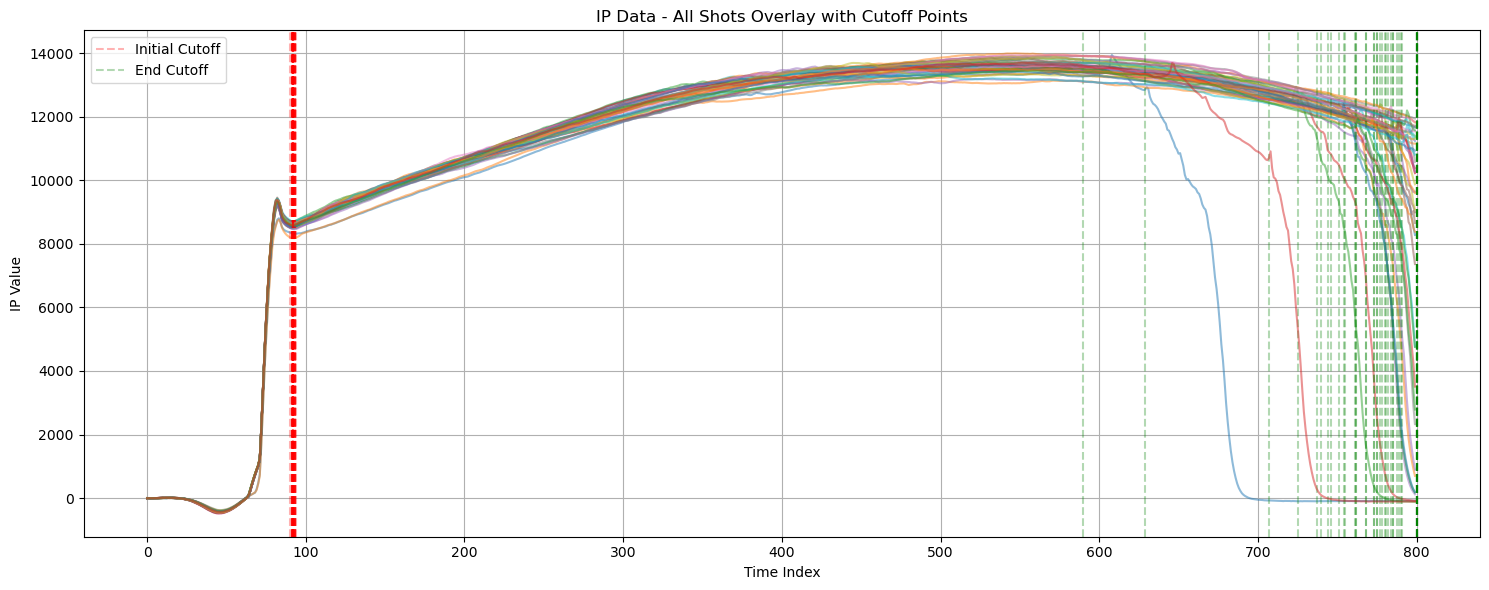

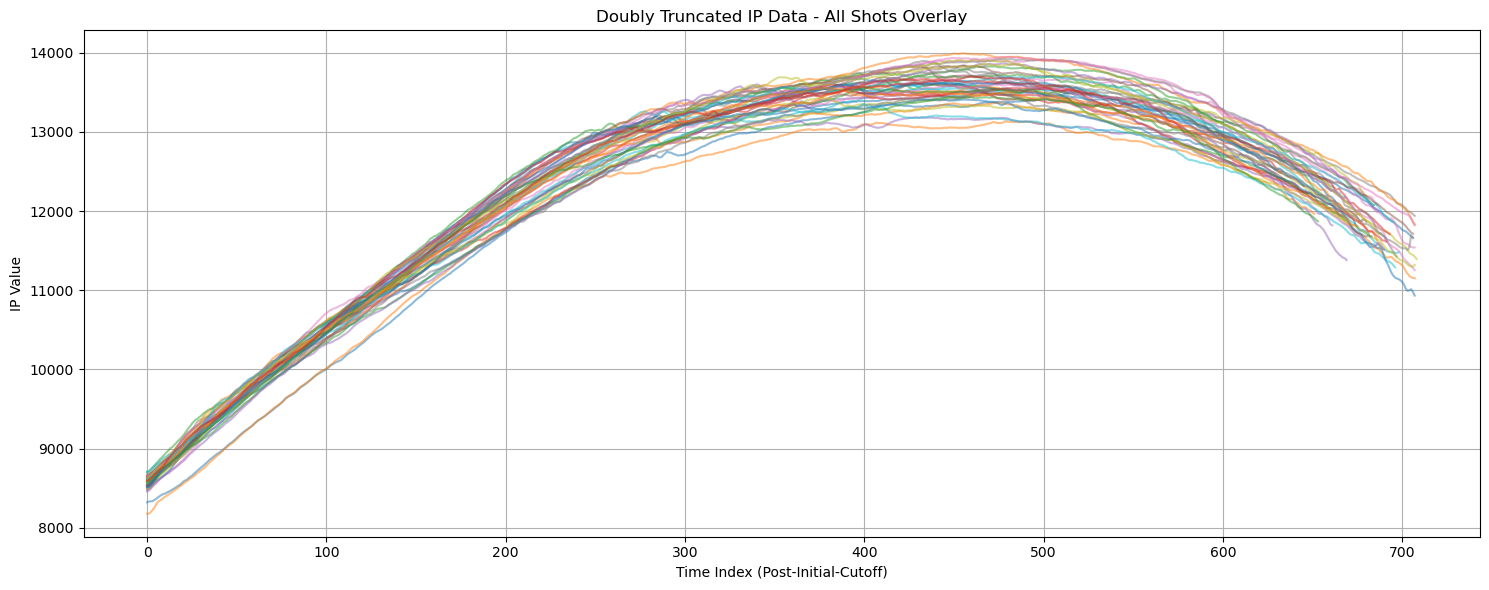

In [61]:
# Graph checks:
# Plot all shots overlaid with cutoff points for validation
plt.figure(figsize=(15, 6))
for i, shot_num in enumerate(shot_list):
    plt.plot(formatted_ip_data[i, :, 0], alpha=0.5)
    plt.axvline(initial_cutoff_indices[i], color='r', linestyle='--', alpha=0.3, label='Initial Cutoff' if i == 0 else "")
    plt.axvline(end_cutoff_indices[i], color='g', linestyle='--', alpha=0.3, label='End Cutoff' if i == 0 else "")
plt.title('IP Data - All Shots Overlay with Cutoff Points')
plt.xlabel('Time Index')
plt.ylabel('IP Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot truncated IP data (post-initial-cutoff, pre-end-cutoff) overlaid
plt.figure(figsize=(15, 6))
for i, shot_num in enumerate(shot_list):
    start_cutoff = initial_cutoff_indices[i]
    end_cutoff = end_cutoff_indices[i]
    truncated_ip = formatted_ip_data[i, start_cutoff:end_cutoff, 0]
    plt.plot(truncated_ip, alpha=0.5)
plt.title('Doubly Truncated IP Data - All Shots Overlay')
plt.xlabel('Time Index (Post-Initial-Cutoff)')
plt.ylabel('IP Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

np.save("formatted_ip_data.npy", formatted_ip_data)